In [1]:
#All neccesary classes for project

#general
import seaborn as sns
import scipy.stats as ss
import pandas as pd
import numpy as np
import os
import pickle
import time
import sys


import tensorflow as tf

#for utility packages
from Utilities.utilities import import_data
from Utilities.utilities import reset_graph

from functools import partial

#image manipulation
from PIL import Image as PI
from resizeimage import resizeimage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import imagenet_helper_files.vgg_preprocessing
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import resnet_v2
from tensorflow.contrib.slim.nets import inception
import imagenet_helper_files.pnasnet as nas

#Import Custom Functions
from Utilities.model_builder import get_image
from Utilities.model_builder import parse_record
from Utilities.model_builder import get_batch
from Utilities.model_builder import build_iterator
from Utilities.model_builder import build_dataset
from Utilities.bounded_model_builder import build_bounded_iterator
from Utilities.bounded_model_builder import build_bounded_iterator_points
from Utilities.model_builder import get_values_imagenet
from Utilities.model_builder import get_values_bounded
from Utilities.model_builder import get_values_bounded_points
from Utilities.models import log_dir_build
from Utilities.utilities import generate_image
from Utilities.utilities import generate_image_array
from Utilities.build_image_data_notebook import process_dataset

from Utilities.utilities import get_ground_truth_string
from Utilities.utilities import find_new_imagenet_ground_truth_int
from Utilities.cell_net_predictor import Binary_Categorical_Predictor
from Utilities.build_image_data_notebook import process_dataset
from Utilities.sample_counter import get_likelihood_avg
from Utilities.sample_counter import get_sample_number
from Utilities.sample_counter import get_likelihood_stdev

from tan.tan_util import get_tan_nll as tan
from tan.tan_util import get_tan_nll_cond as tan_cond

#For building sets
from Utilities.set_builder import add_3_of_a_kind
from Utilities.set_builder import add_1_2_of_a_kind
from Utilities.set_builder import add_2_1_of_a_kind
from Utilities.set_builder import add_3_different
from Utilities.set_builder import append_set
from Utilities.set_record_maker import process_set_arrays
from sklearn.model_selection import train_test_split

#For parsing records once written
from Utilities.set_record_parser import build_set_dataset
from Utilities.set_record_parser import get_file_lists

c:\users\sdgeo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load the Data

Load the data, classes, and check that the tf_records are correct

In [2]:
#Location for all the training Data
#Set Variables

labels_file = "D:/Machine_Learning/Datasets/ImageNet_2012/labels.txt"
image_directory = 'D:/Machine_Learning/Datasets/ImageNet_2012/images/'
tf_record_directory = "D:/Machine_Learning/Datasets/ImageNet_2012/tf_records/"
individual_files = "D:/Machine_Learning/Datasets/ImageNet_2012/individual_label_files/"
tf_record_list = "D:/Machine_Learning/Datasets/ImageNet_2012/tf_record_list.txt"

all_list = tf_record_directory + 'all_data-00000-of-00001'
all_list = np.expand_dims(all_list,0)
all_list

array(['D:/Machine_Learning/Datasets/ImageNet_2012/tf_records/all_data-00000-of-00001'],
      dtype='<U77')

In [3]:
#Import TFRecords for both Training and Testing of the Dat
#Use the build_image_data.py to create these sets from your data
class_file = open(labels_file,'r')
labels = class_file.read().split('\n')
class_file.close()

records_file = open(tf_record_list, 'r')
all_records = records_file.read().split('\n')
records_file.close()


In [4]:
#Build tf_records

num_threads = 1
num_shards = 1

#make validation records
#process_dataset('all_data', image_directory, num_shards, labels_file, num_threads, tf_record_directory)

# Make sure the training Data is good

Here we will import a tf reccord and ensure the data is good

In [14]:
#Build a workflow to extract the data 
reset_graph()

filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
training = tf.placeholder_with_default(True, shape=(), name = 'training')
handle = tf.placeholder(tf.string, shape=[], name="Dataset")

training_set = build_dataset(True, filename, batch_size, num_epochs, num_parallel_calls=8)
val_set = build_dataset(False, filename, batch_size, num_epochs, num_parallel_calls=8)

train_iterator = training_set.make_initializable_iterator()
val_iterator = val_set.make_initializable_iterator()



iterator = tf.data.Iterator.from_string_handle(
    handle, training_set.output_types, training_set.output_shapes)
next_element = iterator.get_next()
X_data, y_data, file = next_element

X = tf.placeholder_with_default(X_data, [None,331,331,3])
y = tf.placeholder_with_default(y_data, [None])


In [13]:
#Test pulling a piece of data out of the set to ensure that records were created properly

random_class = np.random.randint(0,1000);
with tf.Session() as sess:
    record_to_grab = all_records[random_class]
    record_file = np.expand_dims(record_to_grab,0)
    sess.run(train_iterator.initializer, feed_dict={filename: record_file, batch_size: 1, num_epochs:1})
    train_handle = sess.run(train_iterator.string_handle())
    
    
    X_test, y_test, file_test = sess.run([X,y,file], feed_dict={handle: train_handle,training: False})

  

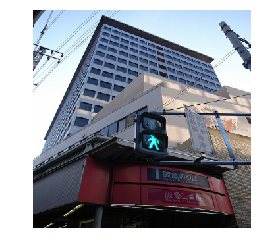

In [14]:
#Show and Image from set
x_val = X_test.reshape(331,331,3)

from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.axis('off')
plt.show()

In [15]:
#Check Class
labels[random_class]

'traffic_light'

In [16]:
#Check the file
file_test

array([b'ILSVRC2012_val_00047101.JPEG'], dtype=object)

# Build the Neural Network

Here we will build the Nas-Net and then stack our own network on top

In [31]:

#import pnas_net model

#Nasnet Model Location
res_net_model = 'D:/AI/models/res_net/v2_152/resnet_v2_152.ckpt'

#directory for logs in training
set_net_logs = 'D:/AI/models/set_maker/logs'
model_path = log_dir_build(set_net_logs, "set_maker")

#directory for all the models saved during training
set_net_model = 'D:/AI/models/set_maker/model/' + 'set_maker'
#set_net_model = 'C:/Programming/Machine_Learning/models' + 'set_maker'


In [32]:
#the graph 
reset_graph()

number_of_classes = 1000

#Set up data Pipeline 
with tf.name_scope("Data_Retriever"):
    filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
    batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
    num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
    training = tf.placeholder_with_default(True, shape=(), name = 'training')
    handle = tf.placeholder(tf.string, shape=[], name="Dataset")

    training_set = build_dataset(True, filename, batch_size, num_epochs, num_parallel_calls=8)

    train_iterator = training_set.make_initializable_iterator()

    iterator = tf.data.Iterator.from_string_handle(
        handle, training_set.output_types, training_set.output_shapes)
    next_data = iterator.get_next()
    X_data, y_data, file = next_data
    X = tf.placeholder_with_default(X_data, shape=[None,331,331,3], name="Image_Data")




with slim.arg_scope(resnet_v2.resnet_arg_scope()):
    resnet_v2.resnet_v2_152(X, num_classes=1001, is_training=False)
    
    desired_code = tf.stop_gradient(tf.layers.flatten(tf.get_default_graph().get_tensor_by_name("resnet_v2_152/pool5:0")))
    print(desired_code)
    
    #A saver to load the pretrained Data
    saver = tf.train.Saver(name="Original_Saver")
    
    
init = tf.global_variables_initializer()    
saver_total = tf.train.Saver(name="Full_Graph")

Tensor("StopGradient:0", shape=(?, 2048), dtype=float32)


In [6]:
#Write Graph to log directory
filewriter = tf.summary.FileWriter(model_path, tf.get_default_graph())

# Initalize RESNET Net

Restore the Parameters from the pre-trained Res Net and initialize all the savers

In [33]:
#Initialize all variables and restore the lower layer
with tf.Session() as sess:
    #Initalizer all variables
    init.run()
    
    #Restore the pretrained variables from Nas-Net
    #saver.restore(sess, res_net_model)
        
    #Save all of these variables to the new Cell_Net Model
    saver_total.save(sess, set_net_model)


# Build Sets

Here we are going to build the sets and export them as tf_records


In [6]:
#Run initialized Network
number_of_sets = 10

image_set_array = np.empty([1,3,331,331,3])
code_set_array = np.empty([1,3,2048])
file_set_array = np.empty([1,3,1])
correct_class_array = np.empty([1,3,1], dtype=np.int)
number_different_classes = np.empty([1,1], dtype=np.int)


with tf.Session() as sess:
    saver_total.restore(sess, set_net_model)

    
    for i in range(0,number_of_sets):
        
        classes_choice = np.random.choice(100, 3, replace=False)
        random_class_1 = classes_choice[0]
        random_class_2 = classes_choice[1]
        random_class_3 = classes_choice[2]
        
        #code_1
        record_file = np.expand_dims(all_records[random_class_1],0)
        sess.run(train_iterator.initializer, feed_dict={filename: record_file, batch_size: 50, num_epochs:1})
        train_handle = sess.run(train_iterator.string_handle())
        X_1, code_1, file_1 = sess.run([X,desired_code,file], feed_dict={handle: train_handle,training: True})
        
        index = np.random.choice(50, 3, replace=False)
        X_1 = X_1[index]
        code_1 = code_1[index]
        file_1 = file_1[index]
        
        #code_2
        record_file = np.expand_dims(all_records[random_class_2],0)
        sess.run(train_iterator.initializer, feed_dict={filename: record_file, batch_size: 50, num_epochs:1})
        train_handle = sess.run(train_iterator.string_handle())
        X_2, code_2, file_2 = sess.run([X,desired_code,file], feed_dict={handle: train_handle,training: True})
        
        index = np.random.choice(50, 3, replace=False)
        X_2 = X_2[index]
        code_2 = code_2[index]
        file_2 = file_2[index]
        
        #code_3
        record_file = np.expand_dims(all_records[random_class_3],0)
        sess.run(train_iterator.initializer, feed_dict={filename: record_file, batch_size: 50, num_epochs:1})
        train_handle = sess.run(train_iterator.string_handle())
        X_3, code_3, file_3 = sess.run([X,desired_code,file], feed_dict={handle: train_handle,training: True})
        
        index = np.random.choice(50, 3, replace=False)
        X_3 = X_3[index]
        code_3 = code_3[index]
        file_3 = file_3[index]
        
        #Add Set of 3
        images, codes, files, class_array, diff_classes = add_3_of_a_kind(X_1, code_1, file_1, random_class_1)
        image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                   image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)
        
        images, codes, files, class_array, diff_classes = add_3_of_a_kind(X_2, code_2, file_2, random_class_2)
        image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                   image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)

        images, codes, files, class_array, diff_classes = add_3_of_a_kind(X_3, code_3, file_3, random_class_3)
        image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                   image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)
        
        
        if i % 2 == 0:
            images, codes, files, class_array, diff_classes = add_2_1_of_a_kind(X_1, code_1, file_1, random_class_1, X_2, code_2, file_2, random_class_2)
            image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                       image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)

            images, codes, files, class_array, diff_classes = add_2_1_of_a_kind(X_2, code_2, file_2, random_class_2, X_3, code_3, file_3, random_class_3)
            image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                       image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)

            images, codes, files, class_array, diff_classes = add_2_1_of_a_kind(X_3, code_3, file_3, random_class_3, X_1, code_1, file_1, random_class_1)
            image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                       image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)
        
        if i % 2 == 1:
        #Add Set of 1-2
            images, codes, files, class_array, diff_classes = add_1_2_of_a_kind(X_1, code_1, file_1, random_class_1, X_2, code_2, file_2, random_class_2)
            image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                       image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)

            images, codes, files, class_array, diff_classes = add_1_2_of_a_kind(X_2, code_2, file_2, random_class_2, X_3, code_3, file_3, random_class_3)
            image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                       image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)

            images, codes, files, class_array, diff_classes = add_1_2_of_a_kind(X_3, code_3, file_3, random_class_3, X_1, code_1, file_1, random_class_1)
            image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                       image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)
        
        #Add Set of 3
        images, codes, files, class_array, diff_classes = add_3_different(X_1, code_1, file_1, random_class_1, X_2, code_2, file_2, random_class_2,  X_3, code_3, file_3, random_class_3)
        image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                   image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)
        
        images, codes, files, class_array, diff_classes = add_3_different(X_2, code_2, file_2, random_class_2, X_3, code_3, file_3, random_class_3, X_1, code_1, file_1, random_class_1)
        image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                   image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)

        images, codes, files, class_array, diff_classes = add_3_different(X_3, code_3, file_3, random_class_3, X_1, code_1, file_1, random_class_1, X_2, code_2, file_2, random_class_2)
        image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes = append_set(images, codes, files, class_array, diff_classes, 
                   image_set_array, code_set_array, file_set_array, correct_class_array, number_different_classes)
        
        image_set_array = np.empty([1,3,331,331,3])
        
        if i % 1000 == 0:
            print("Finished " + str(i))

#remeve empty elements from start        
             
image_set_array = np.delete(image_set_array, 0, axis=0)
code_set_array = np.delete(code_set_array, 0, axis=0)
file_set_array = np.delete(file_set_array, 0, axis=0)
correct_class_array = np.delete(correct_class_array, 0, axis=0)
number_different_classes = np.delete(number_different_classes, 0, axis=0)        

INFO:tensorflow:Restoring parameters from C:/Programming/Machine_Learning/modelsset_maker


NameError: name 'all_records' is not defined

# Check Data

Here we are going to check the data to make sure it is correct before building TF_Records

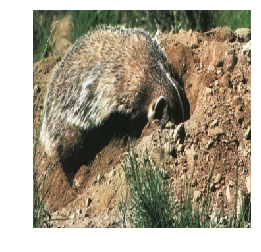

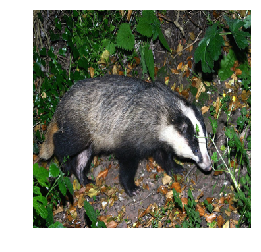

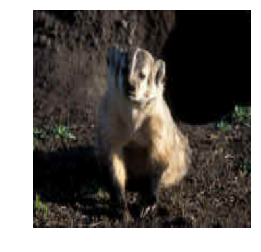

In [21]:
#Show and Image from set
for j in range(0, 1):
    for i in range(0,3):
        X_test = image_set_array[j][i]
        x_val = X_test.reshape(331,331,3)

        from matplotlib import pyplot as plt
        plt.imshow(x_val, interpolation='nearest')
        plt.axis('off')
        plt.show()

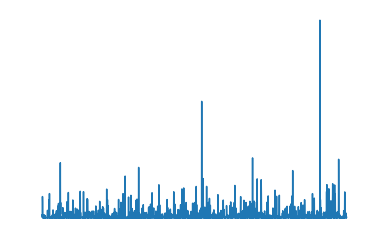

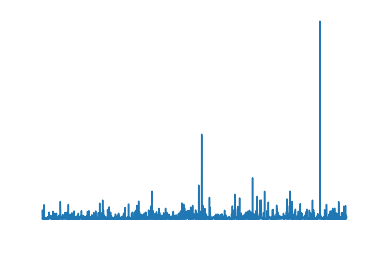

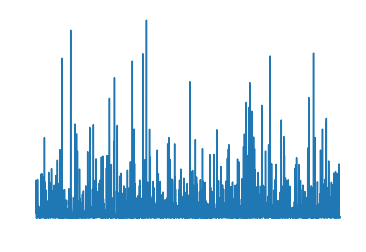

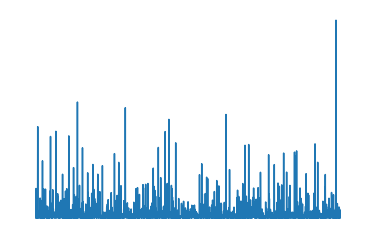

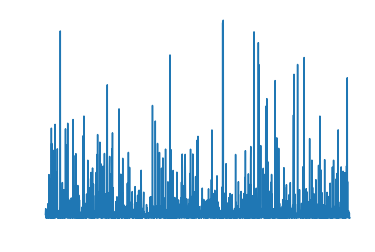

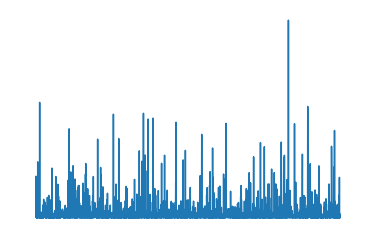

In [22]:
#Show and Image from set
for j in range(0, number_of_sets):
    for i in range(0,3):
        X_test = code_set_array[j][i]
        x_val = X_test

        from matplotlib import pyplot as plt
        plt.plot(x_val)
        plt.axis('off')
        plt.show()

In [23]:
classes = correct_class_array[0][0][0]
print(classes)
#Check Class
labels[classes]

15


'badger'

In [134]:
print(image_set_array.shape)
print(code_set_array.shape)
print(file_set_array.shape)
print(correct_class_array.shape)
print(number_different_classes.shape)

(0, 3, 331, 331, 3)
(90000, 3, 2048)
(90000, 3, 1)
(90000, 3, 1)
(90000, 1)


In [135]:
#Split data into train, test, and validation
code_set_array_train, code_set_array_validation, file_set_array_train, file_set_array_validation, correct_class_array_train, correct_class_array_validation, number_different_classes_train, number_different_classes_validation = train_test_split(code_set_array, file_set_array, 
                                                                                                                  correct_class_array, number_different_classes, 
                                                                                                                  test_size=0.3, random_state=42)


In [136]:
print(code_set_array_train.shape)
print(file_set_array_train.shape)
print(correct_class_array_train.shape)
print(number_different_classes_train.shape)

(63000, 3, 2048)
(63000, 3, 1)
(63000, 3, 1)
(63000, 1)


In [137]:
print(code_set_array_validation.shape)
print(file_set_array_validation.shape)
print(correct_class_array_validation.shape)
print(number_different_classes_validation.shape)

(27000, 3, 2048)
(27000, 3, 1)
(27000, 3, 1)
(27000, 1)


# Build TF_Records

Here we will use the sets above to write TF_Records

In [5]:
output_dir = 'D:/Machine_Learning/Datasets/Set_Project/Code_Class_TF_Records'
#output_dir = 'C:/Programming/Datasets/Set_Dataset'

In [138]:
name = 'Training_Set_Small'

process_set_arrays(name, code_set_array_train, file_set_array_train, correct_class_array_train, number_different_classes_train, 2, 2, output_dir)

name = 'Validation_Set_small'
process_set_arrays(name, code_set_array_validation, file_set_array_validation, correct_class_array_validation, number_different_classes_validation, 2, 2, output_dir)

Launching 2 threads for spacings: [[0, 31500], [31500, 63000]]
2019-02-09 21:21:09.107974 [thread 0]: Processed 1000 of 31500 images in thread batch.2019-02-09 21:21:09.113973 [thread 1]: Processed 1000 of 31500 images in thread batch.

2019-02-09 21:21:10.533973 [thread 0]: Processed 2000 of 31500 images in thread batch.
2019-02-09 21:21:10.537975 [thread 1]: Processed 2000 of 31500 images in thread batch.
2019-02-09 21:21:11.949974 [thread 0]: Processed 3000 of 31500 images in thread batch.
2019-02-09 21:21:11.957974 [thread 1]: Processed 3000 of 31500 images in thread batch.
2019-02-09 21:21:13.367973 [thread 0]: Processed 4000 of 31500 images in thread batch.
2019-02-09 21:21:13.374974 [thread 1]: Processed 4000 of 31500 images in thread batch.
2019-02-09 21:21:14.786974 [thread 0]: Processed 5000 of 31500 images in thread batch.
2019-02-09 21:21:14.790974 [thread 1]: Processed 5000 of 31500 images in thread batch.
2019-02-09 21:21:16.201974 [thread 0]: Processed 6000 of 31500 imag

# Import Records  

Here we are going to test the records we just built

In [57]:
train_list, val_list = get_file_lists(output_dir)
train_list

['D:/Machine_Learning/Datasets/Set_Project/Code_Class_TF_Records\\Training_Set-00000-of-00002',
 'D:/Machine_Learning/Datasets/Set_Project/Code_Class_TF_Records\\Training_Set-00001-of-00002']

In [7]:
reset_graph()

filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
training = tf.placeholder_with_default(True, shape=(), name = 'training')
handle = tf.placeholder(tf.string, shape=[], name="Dataset")
code_size = 2048
set_size = 3

training_set = build_set_dataset(True, filename, code_size, set_size, batch_size, num_epochs, num_parallel_calls=8)

train_iterator = training_set.make_initializable_iterator()

iterator = tf.data.Iterator.from_string_handle(
    handle, training_set.output_types, training_set.output_shapes)
next_element = iterator.get_next()
code_data, class_data, file_data, uniques_data = next_element

code = tf.placeholder_with_default(code_data, [None,3,2048])
uniques = tf.placeholder_with_default(uniques_data, [None])

Tensor("Cast:0", shape=(3, 2048), dtype=float16) Tensor("Cast_1:0", shape=(3,), dtype=int16) Tensor("ParseSingleExample/ParseSingleExample:3", shape=(), dtype=string) Tensor("Cast_2:0", shape=(), dtype=int16)


In [9]:
with tf.Session() as sess:
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: 1, num_epochs:1})
    train_handle = sess.run(train_iterator.string_handle())

    test_code, test_class, test_file, test_unique = sess.run([code, class_data, file_data, uniques], feed_dict={handle: train_handle,training: False})

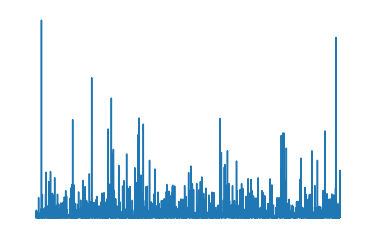

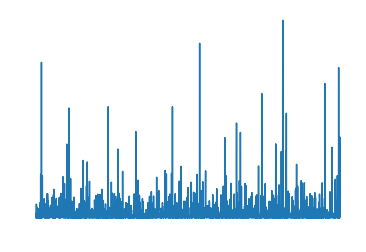

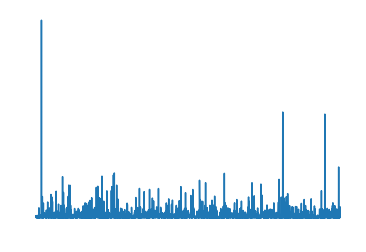

In [10]:
#Show codes from single example
for i in range(0,3):
    X_test = test_code[0][i]
    x_val = X_test

    from matplotlib import pyplot as plt
    plt.plot(x_val)
    plt.axis('off')
    plt.show()

In [17]:
#Show codes from single example
for i in range(0,3):
    X_test = test_class[0][i]
    print('Class: ' + str(X_test) + ' Label: ' + labels[X_test])
    

Class: 11 Label: gazelle
Class: 11 Label: gazelle
Class: 11 Label: gazelle


In [12]:
print(test_file)

[b'ILSVRC2012_val_00039366.JPEG,ILSVRC2012_val_00046413.JPEG,ILSVRC2012_val_00023933.JPEG,']


In [13]:
print(test_unique)

[1]
